# CS539 Final Project

## Topic: Battle Result Prediction and Image Generator Based on GAN in Pokemon

### Group Member: Lei Guo, Mengzhi Cao, Huanzhen Zhang, Chao Wang, Xinye Fan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import prettytable
import time
import os
from sklearn.metrics import confusion_matrix
%matplotlib inline

## 1. Data Visualization

In [5]:
pokemon = pd.read_csv('./data_part1/pokemon.csv')

del pokemon['Generation']
del pokemon['Legendary']

pokemon.loc[pokemon['Type 2'].isnull(),'Type 2'] = pokemon[pokemon['Type 2'].isnull()]['Type 1']
dummy1 = pd.get_dummies(pokemon.loc[:,'Type 1'])
dummy2 = pd.get_dummies(pokemon.loc[:,'Type 2'])

In [27]:
combats = pd.read_csv('./data_part2/combats.csv')

combats_array = np.array(combats)
for i in range(combats_array.shape[0]):
    for j in range(combats_array.shape[1]):
        if combats_array[i][2] == combats_array[i][0]:
            combats_array[i][2] = 0
        elif combats_array[i][2] == combats_array[i][1]:
             combats_array[i][2] = 1

combats = pd.DataFrame(data = combats_array, index = np.arange(1, 50001), columns = np.arange(1, 4))
label = combats[3]

In [28]:
Type_table = np.zeros((18, 18))
Type_table[0,:] = [1,1,1,1,1,0.5,1,0,0.5,1,1,1,1,1,1,1,1,1]
Type_table[1,:] = [2,1,0.5,0.5,1,2,0.5,0,2,1,1,1,1,0.5,2,1,2,0.5]
Type_table[2,:] = [1,2,1,1,1,0.5,2,1,0.5,1,1,2,0.5,1,1,1,1,1]
Type_table[3,:] = [1,1,1,0.5,0.5,0.5,1,0.5,0,1,1,2,1,1,1,1,1,2]
Type_table[4,:] = [1,1,0,2,1,2,0.5,1,2,2,1,0.5,2,1,1,1,1,1]
Type_table[5,:] = [1,0.5,2,1,0.5,1,2,1,0.5,2,1,1,1,1,2,1,1,1]
Type_table[6,:] = [1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,2,1,2,1,1,2,0.5]
Type_table[7,:] = [0,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,1]
Type_table[8,:] = [1,1,1,1,1,2,1,1,0.5,0.5,0.5,1,0.5,1,2,1,1,2]
Type_table[9,:] = [1,1,1,1,1,0.5,2,1,2,0.5,0.5,2,1,1,2,0.5,1,1]
Type_table[10,:] = [1,1,1,1,2,2,1,1,1,2,0.5,0.5,1,1,1,0.5,1,1]
Type_table[11,:] = [1,1,0.5,0.5,2,2,0.5,1,0.5,0.5,2,0.5,1,1,1,0.5,1,1]
Type_table[12,:] = [1,1,2,1,0,1,1,1,1,1,2,0.5,0.5,1,1,0.5,1,1]
Type_table[13,:] = [1,2,1,2,1,1,1,1,0.5,1,1,1,1,0.5,1,1,0,1]
Type_table[14,:] = [1,1,2,1,2,1,1,1,0.5,0.5,0.5,2,1,1,0.5,2,1,1]
Type_table[15,:] = [1,1,1,1,1,1,1,1,0.5,1,1,1,1,1,1,2,1,0]
Type_table[16,:] = [1,0.5,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,0.5]
Type_table[17,:] = [1,2,1,0.5,1,1,1,1,0.5,0.5,1,1,1,1,1,2,2,1]
Type_table = pd.DataFrame(Type_table)

### Pikachu

In [46]:
pokemon.loc[pokemon['Name']=='Pikachu']

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
30,31,Pikachu,Electric,Electric,35,55,40,50,50,90


In [56]:
labels = np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
stats = pokemon.loc[30,labels].values
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

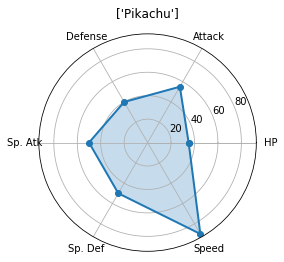

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title([df.loc[30,"Name"]])
ax.grid(True)

### Squirtle

In [58]:
pokemon.loc[pokemon['Name']=='Squirtle']

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
9,10,Squirtle,Water,Water,44,48,65,50,64,43


In [59]:
labels = np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
stats = pokemon.loc[9,labels].values
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

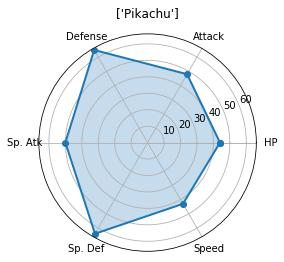

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title([df.loc[30,"Name"]])
ax.grid(True)

## 2. Feature Engineering

In [62]:
def type_result(BA, Pokemon_table, Type1, Type2, index_1, index_2):
    Pokemon1 = Pokemon_table.loc[index_1-1]
    Pokemon2 = Pokemon_table.loc[index_2-1]

    pokemon_1_type1 = Type1.loc[index_1-1].values
    pokemon_1_type2 = Type2.loc[index_1-1].values
    pokemon_2_type1 = Type1.loc[index_2-1].values
    pokemon_2_type2 = Type2.loc[index_2-1].values

    pokemon_1 = np.vstack([pokemon_1_type1,pokemon_1_type2])
    pokemon_2 = np.vstack([pokemon_2_type1,pokemon_2_type2])

    ATdivDF1 = Pokemon1['Attack'] / Pokemon2['Defense']
    ATdivDF2 = Pokemon2['Attack'] / Pokemon1['Defense']
    SATdivSDF1 = Pokemon1['Sp. Atk'] / Pokemon2['Sp. Def']
    SATdivSDF2 = Pokemon2['Sp. Atk'] / Pokemon1['Sp. Def']
    Speed = np.sign(Pokemon1['Speed'] - Pokemon2['Speed'])
    HPsub = Pokemon1['HP'] - Pokemon2['HP']

    result1 = (pokemon_1.dot(BA)).dot(pokemon_2.T)
    result2 = (pokemon_2.dot(BA)).dot(pokemon_1.T)

    result_1 = result1[:,0] * result1[:,1]
    result_2 = result2[:,0] * result2[:,1]
    
    result1 = result_1.max()
    result2 = result_2.max()

    return [HPsub, ATdivDF1, ATdivDF2, SATdivSDF1, SATdivSDF2, Speed, result1, result2]

In [63]:
%%time
y = []
for index in combats.itertuples():
    x = type_result(Type_table, pokemon, dummy1, dummy2, index[1], index[2])
    y = np.hstack([y,x])
y = np.reshape(y,(50000,8))

CPU times: user 2min 19s, sys: 3.51 s, total: 2min 22s
Wall time: 47.7 s


## 3. Elo Rating

### 3.1 Algorithms

In [7]:
combats_= pd.read_csv('combats.csv')
combats_array = np.array(combats_)
pokemon = pd.read_csv("pokemon.csv",index_col = 0)

def compute_W_name(combats, pokemon):
    combats_= pd.read_csv('combats.csv')
    pokemon=pd.read_csv('pokemon.csv',index_col = 0)
    combats_array = np.array(combats_)
    for i in range(len(combats_array)):
        if combats_array[i][1]==combats_array[i][2]:
            tem_memory=combats_array[i][0]
            combats_array[i][0]=combats_array[i][1]
            combats_array[i][1]=tem_memory
    combats_new=np.delete(combats_array,2,1)
    pokemon_name = pokemon['Name'].values
    return combats_new, pokemon_name


def compute_EA(RA, RB):
    t=(RB-RA)/400
    EA=1./(1+10**t)
    return EA


def update_RA(RA, SA, EA, K = 16.):
    RA_new=RA+K*(SA-EA)
    return RA_new


def elo_rating(W, n_player, K= 16.):
    R = n_player * [400.] 
    for (A, B) in W:
        A = A -1
        B = B -1
        RA = R[A]
        RB = R[B]
        EA = compute_EA(RA, RB)
        R[A] = update_RA(RA, 1., EA, K)
        EB = 1. - EA 
        R[B] = update_RA(RB, 0., EB, K)
    return R 


def team_rating(conbats_new,pokemon_name,K=16.):
    W=combats_new
    team_names=pokemon_name
    n_player=len(pokemon_name)
    R=elo_rating(W, n_player)
    d=dict(zip(team_names,R))
    a=sorted(d.items(),key=lambda items:items[1],reverse=True)
    top_teams=[]
    top_ratings=[]
    for i in range(len(a)):
        top_teams.append(a[i][0])
        top_ratings.append(a[i][1])
    return top_teams, top_ratings,a

In [8]:
%%time
combats_new, pokemon_name = compute_W_name(combats_, pokemon)
top_pokemons, top_ratings, pokemon_with_ranking = team_rating(combats_new, pokemon_name)

CPU times: user 184 ms, sys: 4.09 ms, total: 188 ms
Wall time: 186 ms


### 3.2 Result

#### 3.2.1 least competitive pokemon

In [11]:
header = ['Rank','Pokemon','Rating']
pt = prettytable.PrettyTable(header)

for i in range(10):
    n = len(pokemon_name)-i
    pt.add_row((n, top_pokemons[n-1], top_ratings[n-1]))

pt.max_width['Text'] = 60
pt.align= 'l'
print(pt)

+------+-----------+---------------------+
| Rank | Pokemon   | Rating              |
+------+-----------+---------------------+
| 800  | Shuckle   | -63.321579274520545 |
| 799  | Solosis   | -38.12634371804656  |
| 798  | Silcoon   | -25.947144398643495 |
| 797  | Slugma    | -10.07910535313023  |
| 796  | Oddish    | -5.413021856253424  |
| 795  | Wynaut    | 5.151525165142679   |
| 794  | Togepi    | 5.248543139799295   |
| 793  | Nosepass  | 6.572496136424364   |
| 792  | Munna     | 6.858230292820831   |
| 791  | Igglybuff | 7.070434988590325   |
+------+-----------+---------------------+


#### 3.2.2 Most competitive pokemon

In [12]:
header = ['Rank','Pokemon','Rating']
pt = prettytable.PrettyTable(header)

for i in range(10):
    pt.add_row((i+1, top_pokemons[i], top_ratings[i]))

pt.max_width['Text'] = 60
pt.align= 'l'
print(pt)

+------+------------------------+-------------------+
| Rank | Pokemon                | Rating            |
+------+------------------------+-------------------+
| 1    | Deoxys Speed Forme     | 828.0302210594525 |
| 2    | Mega Houndoom          | 827.4732867671258 |
| 3    | Tornadus Therian Forme | 825.2798266006375 |
| 4    | Greninja               | 823.0435224169431 |
| 5    | Aerodactyl             | 815.7203686585797 |
| 6    | Mega Aerodactyl        | 808.4111876631479 |
| 7    | Mega Absol             | 807.2476458201553 |
| 8    | Mega Rayquaza          | 804.2765499457327 |
| 9    | Weavile                | 804.2617381720103 |
| 10   | Jolteon                | 794.7547199492315 |
+------+------------------------+-------------------+


## 4.Algorithm

### 4.1 Logistic Regression

#### 4.1.1 Result

In [12]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5,random_state=0, multi_class='multinomial').fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9363

#### 4.1.2 Confusion Matrix

Confusion matrix, without normalization
[[17926   959]
 [ 1755 19360]]
Normalized confusion matrix
[[0.95 0.05]
 [0.08 0.92]]


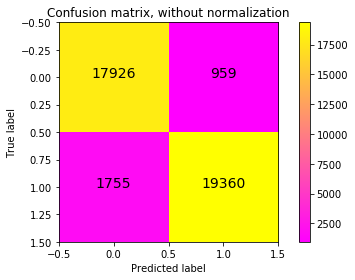

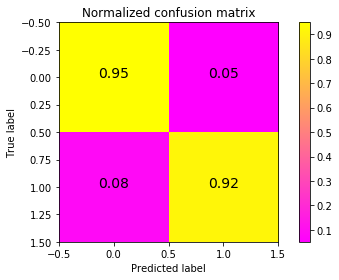

In [13]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.spring):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black",fontsize=14 )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.1.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

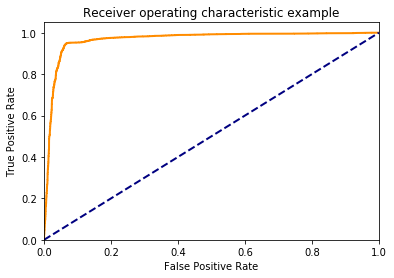

In [14]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.2 Naive Bayes

#### 4.2.1 Result

In [15]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(y[:40000,:], label.loc[:40000])
gnb.score(y[40000:50000,:],label.loc[40001:50000])

0.9306

#### 4.2.2 Confusion Matrix

Confusion matrix, without normalization
[[17704  1181]
 [ 1769 19346]]
Normalized confusion matrix
[[0.94 0.06]
 [0.08 0.92]]


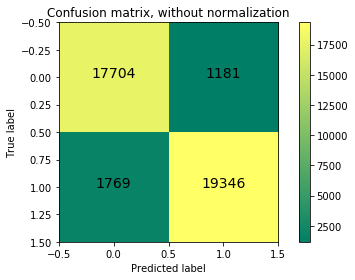

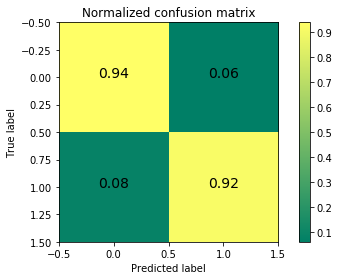

In [16]:
predict = list(gnb.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm,normalize=False, title='Confusion matrix', cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.2.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

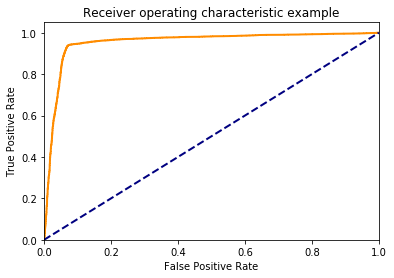

In [17]:
from sklearn.metrics import roc_curve
gnb.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],gnb.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.3 Support Vector Machine

#### 4.3.1 Result

In [27]:
from sklearn import svm
clf = svm.SVC(random_state=0, kernel='rbf', probability=True).fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9387

#### 4.3.2 Confusion Matrix

Confusion matrix, without normalization
[[17999   886]
 [ 1399 19716]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


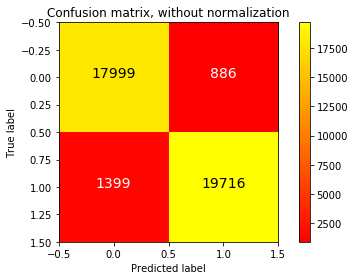

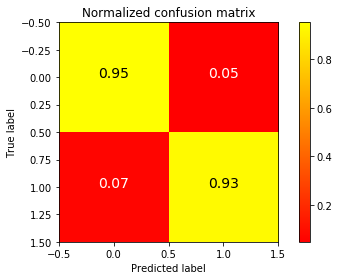

In [28]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.autumn):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.3.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

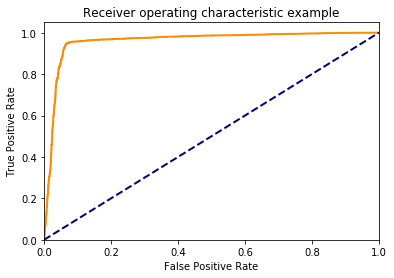

In [29]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.4 Decision Tree

#### 4.4.1 Result

In [64]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=4).fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9416

#### 4.4.2 Confusion Matrix

Confusion matrix, without normalization
[[17920   965]
 [ 1437 19678]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


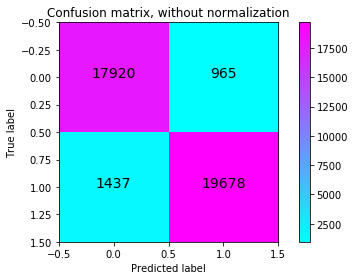

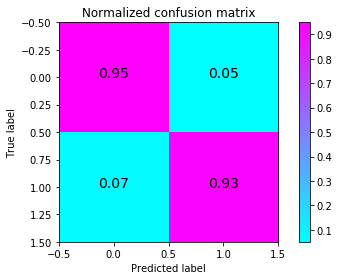

In [65]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm,normalize=False, title='Confusion matrix', cmap=plt.cm.cool):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.4.3 Plot

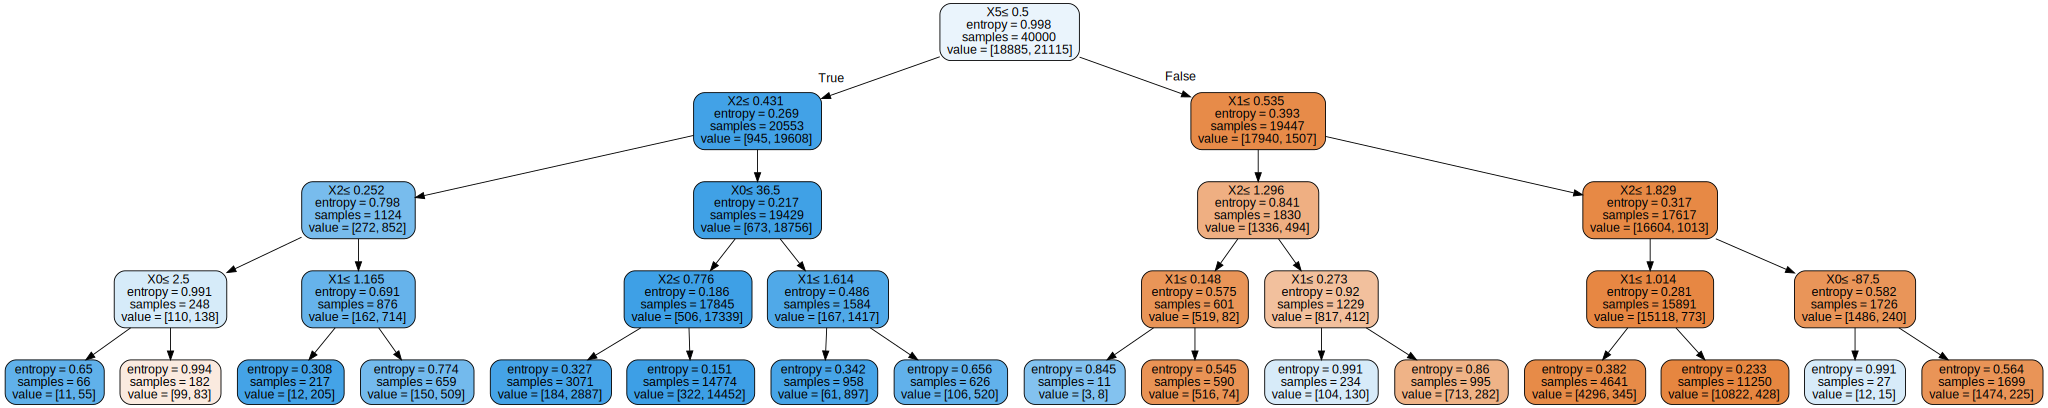

In [66]:
import graphviz
data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, special_characters=True)  
graphviz.Source(data)

### 4.5 KNN

#### 4.5.1 Scale Data

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ytrain_scale = scaler.fit_transform(y[:40000,:])
ytest_scale = scaler.fit_transform(y[40000:50000,:])

#### 4.5.2 Result

In [25]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(ytrain_scale, label.loc[:40000])
clf.score(ytest_scale,label.loc[40001:50000])

0.9384

#### 4.5.3 Confusion Matrix 

Confusion matrix, without normalization
[[4497  277]
 [ 339 4887]]
Normalized confusion matrix
[[0.94 0.06]
 [0.06 0.94]]


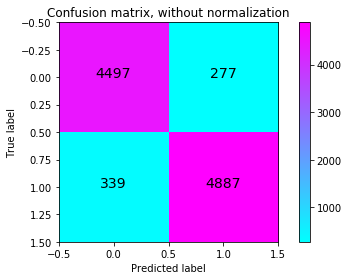

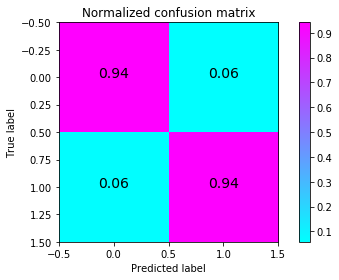

In [29]:
y_test = np.array(label.loc[40001:50000])

def plot_confusion_matrix(cm,normalize=False, title='Confusion matrix', cmap=plt.cm.cool):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

### 4.6 Random Forest

#### 4.6.1 Result

In [35]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=30).fit(y[:40000,:], label.loc[:40000])
clf2.score(y[40000:50000,:],label.loc[40001:50000])

0.9483

#### 4.6.2 Confusion Matrix

Confusion matrix, without normalization
[[18884     1]
 [    0 21115]]
Normalized confusion matrix
[[1.0e+00 5.3e-05]
 [0.0e+00 1.0e+00]]


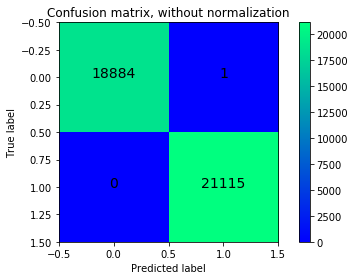

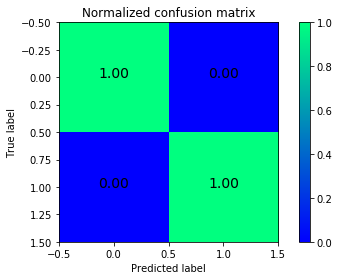

In [36]:
predict = list(clf2.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.6.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

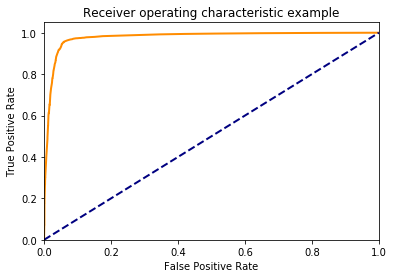

In [37]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.7 Adaboost

#### 4.7.1 Result

In [31]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=0, n_estimators=100).fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9425

#### 4.7.2 Confusion Matrix

Confusion matrix, without normalization
[[17935   950]
 [ 1433 19682]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


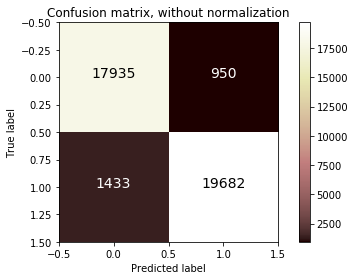

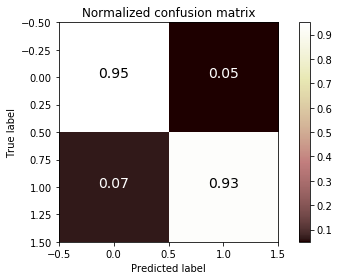

In [32]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.pink):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix,  normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.7.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

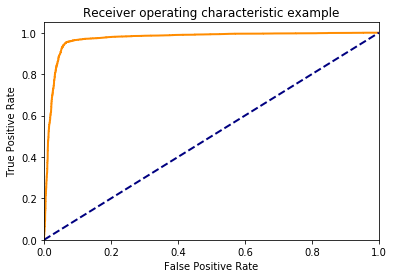

In [33]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.8 Gradient Boosting Tree

#### 4.8.1 Result

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, n_estimators=100).fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9439

#### 4.8.2 Confusion Matrix

Confusion matrix, without normalization
[[18008   877]
 [ 1398 19717]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


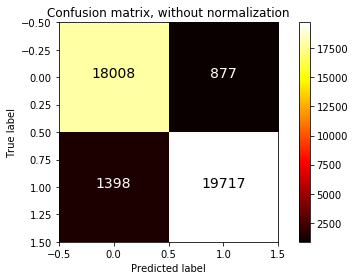

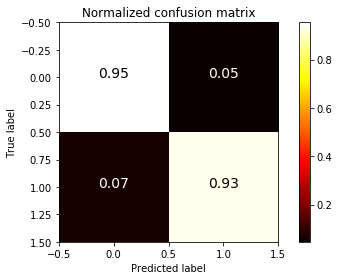

In [42]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.hot):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.8.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

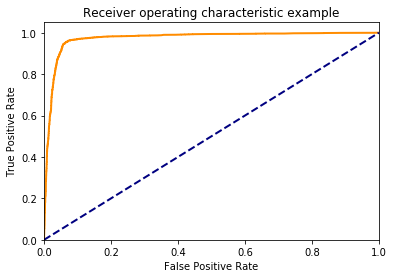

In [43]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

### 4.9 Multi-layer Perceptron

#### 4.9.1 Result

In [44]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, solver='sgd', activation='relu', hidden_layer_sizes=(10, 2)).fit(y[:40000,:], label.loc[:40000])
clf.score(y[40000:50000,:],label.loc[40001:50000])

0.9419

#### 4.9.2 Confusion Matrix

Confusion matrix, without normalization
[[17903   982]
 [ 1487 19628]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


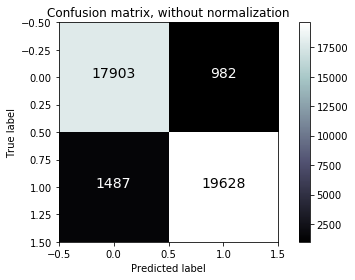

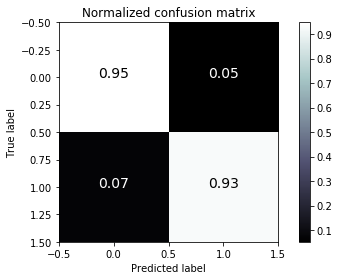

In [45]:
predict = list(clf.predict(y[:40000,:]))
truth = list(label.loc[:40000])
y_pred = np.array(predict)
y_test = np.array(truth)

def plot_confusion_matrix(cm,normalize=False, title='Confusion matrix', cmap=plt.cm.bone):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show();

#### 4.9.3 ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

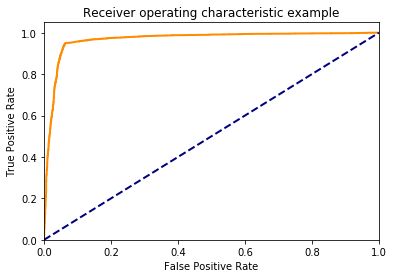

In [46]:
from sklearn.metrics import roc_curve
clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0]
fpr, tpr, thresholds = roc_curve(label.loc[40001:50000],clf.fit(y[:40000,:], label.loc[:40000]).predict_proba(y[40000:50000,:])[:,0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')